In [2]:
!nvidia-smi

Wed Nov  6 04:55:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   60C    P0             13W /   50W |     214MiB /   4096MiB |     35%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
print(os.getcwd())

c:\Users\zhark\Documents\Учёба\ИТМО\CV\2_lab


### Выбор датасета

In [4]:
path = "handmade_apple_orange_dataset"
#r"C:\Users\zhark\Documents\Учёба\ИТМО\CV\2_lab\handmade_apple_orange_dataset"

print("Path to dataset files:", path)

try:
    contents = os.listdir(path)
    print("Содержимое директории:", contents)
except FileNotFoundError:
    print("Указанный путь не найден:", path)
except Exception as e:
    print("Произошла ошибка:", e)

Path to dataset files: handmade_apple_orange_dataset
Содержимое директории: ['apple', 'orange']


In [5]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
import torch
from PIL import Image

In [6]:
# закрепим seed для рандома
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(12345)

In [7]:
# укажем путь до датасета и получим пути до всех изображений
dataset_path = path

image_paths_apple = glob(os.path.join(dataset_path, '**', 'apple', '*.jpg'), recursive=True)
image_paths_orange = glob(os.path.join(dataset_path, '**', 'orange', '*.jpg'), recursive=True)

In [8]:
# проверим сбалансированность датасета
len(image_paths_apple), len(image_paths_orange)

(1261, 1267)

In [9]:
print(image_paths_apple[0], type(image_paths_apple[0]))
cv2.__version__

handmade_apple_orange_dataset\apple\n07740461_10011.jpg <class 'str'>


'4.10.0'

In [10]:
# функция для кодирования изображения в векторное представление

def get_image_feature(image_path, resolution=(128, 128)):
  # откроем изображение, переведем в монохромный режим и отмасштабируем
  image_rgb = cv2.imread(image_path)
  image = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, resolution)

  # получим hog-дескриптор
  hog = cv2.HOGDescriptor()
  feature = hog.compute(image, winStride=(8, 8), padding=(0, 0))
  return feature

In [11]:
# получим пары (feature, label), label=0: wo mask, label=1: w mask
dataset = [(get_image_feature(image_path), 0) for image_path in image_paths_apple] + \
          [(get_image_feature(image_path), 1) for image_path in image_paths_orange]

# перемешаем датасет
random.shuffle(dataset)

# разобьем на 2 части: train и test
dataset_train = dataset[:int(0.8*len(dataset))]
dataset_train_features = [el[0] for el in dataset_train]
dataset_train_labels = [el[1] for el in dataset_train]

dataset_test = dataset[int(0.8*len(dataset)):]
dataset_test_features = [el[0] for el in dataset_test]
dataset_test_labels = [el[1] for el in dataset_test]

print(len(dataset_train), len(dataset_test))

2022 506


### VGG19

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
from tqdm import tqdm
import torch
import torchvision
from torchvision.models import vgg19
import torchvision.transforms as transforms

In [13]:
batch_size = 64
n_epochs = 5

model = vgg19(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# будем обучать бинарную классификацию, поэтому 1 выход
model.classifier = torch.nn.Linear(25088, 1)
# model.fc = torch.nn.Linear(512, 1)

# Явно устанавливаем использование CPU
device = torch.device("cpu")

# Переносим модель на устройство CPU
model.to(device);

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(), # h,w,c -> c,h,w
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = torchvision.datasets.ImageFolder(root='handmade_apple_orange_dataset', transform=transform)

valid_size = int(len(dataset) * 0.1)
train_set, valid_set = torch.utils.data.random_split(dataset, (len(dataset)-valid_size, valid_size))
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [15]:
for epoch in range(1, n_epochs+1):
    train_loss = []
    for batch_i, (data, target) in enumerate(tqdm(train_dataloader)):
        data, target = data.to(device), target.to(device).unsqueeze(1).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()

    with torch.no_grad():
        # запускаем валидацию
        model.eval()
        val_loss = []
        for batch_i, (data, target) in enumerate(valid_dataloader):
            data, target = data.to(device), target.to(device).unsqueeze(1)
            output = model(data)
            loss = criterion(output, target.float())
            val_loss.append(loss.item())

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

100%|██████████| 36/36 [02:32<00:00,  4.23s/it]


Epoch 1, train loss: 0.3032, valid loss: 0.1617.


100%|██████████| 36/36 [02:50<00:00,  4.74s/it]


Epoch 2, train loss: 0.1750, valid loss: 0.1578.


100%|██████████| 36/36 [04:09<00:00,  6.92s/it]


Epoch 3, train loss: 0.1453, valid loss: 0.1202.


100%|██████████| 36/36 [02:50<00:00,  4.74s/it]


Epoch 4, train loss: 0.1307, valid loss: 0.1249.


100%|██████████| 36/36 [02:55<00:00,  4.87s/it]


Epoch 5, train loss: 0.1211, valid loss: 0.1146.


In [16]:
model.to(device)
model.eval()
pred_list = []; y_list = []
for x, y in valid_dataloader:
    with torch.no_grad():
        x = x.to(device)
        y = y.float().to(device)
        output = model(x)
        pred = torch.sigmoid(output)
        pred = pred.cpu().detach().numpy()
        for i in range(pred.shape[0]):
            pred_list.append(pred[i][0])
            y_list.append(int(y[i].item()))

model_prs = []
for model_pr, true_pr in zip(pred_list, y_list):
    model_pr = 1 if model_pr >= 0.5 else 0
    model_prs.append(model_pr)

In [17]:
# распечатаем результаты классификации на тестовой выборке
print(classification_report(np.array(y_list), np.array(model_prs)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       117
           1       0.97      0.94      0.95       135

    accuracy                           0.95       252
   macro avg       0.95      0.95      0.95       252
weighted avg       0.95      0.95      0.95       252



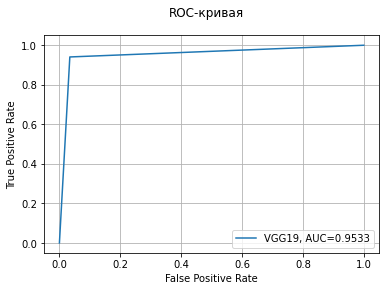

In [18]:
fpr_vgg19, tpr_vgg19, _ = metrics.roc_curve(np.array(y_list), np.array(model_prs))
auc_vgg19 = round(metrics.roc_auc_score(np.array(y_list), np.array(model_prs)), 4)
plt.plot(fpr_vgg19, tpr_vgg19, label="VGG19, AUC=" + str(auc_vgg19))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('ROC-кривая')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
#plt.plot(fpr_rfc, tpr_rfc, label="Random Forest, AUC=" + str(auc_rfc))
#plt.plot(fpr_svm, tpr_svm, label="SVM, AUC=" + str(auc_svm))
#plt.plot(fpr_gbc, tpr_gbc, label="Gradient Boosting, AUC=" + str(auc_gbc))

### ResNet18

In [20]:
from torchvision.models import resnet18

In [21]:
# Загружаем предобученную модель resnet18
model = resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Изменяем последний слой для бинарной классификации
model.fc = torch.nn.Linear(512, 1)

# Явно устанавливаем использование CPU
device = torch.device("cpu")

# Переносим модель на устройство CPU
model.to(device);

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(), # h,w,c -> c,h,w
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = torchvision.datasets.ImageFolder(root='handmade_apple_orange_dataset', transform=transform)

valid_size = int(len(dataset) * 0.1)
train_set, valid_set = torch.utils.data.random_split(dataset, (len(dataset)-valid_size, valid_size))
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [23]:
for epoch in range(1, n_epochs+1):
    train_loss = []
    for batch_i, (data, target) in enumerate(tqdm(train_dataloader)):
        data, target = data.to(device), target.to(device).unsqueeze(1).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()

    with torch.no_grad():
        # запускаем валидацию
        model.eval()
        val_loss = []
        for batch_i, (data, target) in enumerate(valid_dataloader):
            data, target = data.to(device), target.to(device).unsqueeze(1)
            output = model(data)
            loss = criterion(output, target.float())
            val_loss.append(loss.item())

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

100%|██████████| 36/36 [00:36<00:00,  1.03s/it]


Epoch 1, train loss: 0.7027, valid loss: 0.6593.


100%|██████████| 36/36 [00:29<00:00,  1.22it/s]


Epoch 2, train loss: 0.6417, valid loss: 0.6013.


100%|██████████| 36/36 [00:27<00:00,  1.31it/s]


Epoch 3, train loss: 0.5880, valid loss: 0.5553.


100%|██████████| 36/36 [00:38<00:00,  1.08s/it]


Epoch 4, train loss: 0.5437, valid loss: 0.5191.


100%|██████████| 36/36 [00:41<00:00,  1.14s/it]


Epoch 5, train loss: 0.5092, valid loss: 0.4893.


In [24]:
model.to(device)
model.eval()
pred_list = []; y_list = []
for x, y in valid_dataloader:
    with torch.no_grad():
        x = x.to(device)
        y = y.float().to(device)
        output = model(x)
        pred = torch.sigmoid(output)
        pred = pred.cpu().detach().numpy()
        for i in range(pred.shape[0]):
            pred_list.append(pred[i][0])
            y_list.append(int(y[i].item()))

model_prs = []
for model_pr, true_pr in zip(pred_list, y_list):
    model_pr = 1 if model_pr >= 0.5 else 0
    model_prs.append(model_pr)

In [25]:
# распечатаем результаты классификации на тестовой выборке
print(classification_report(np.array(y_list), np.array(model_prs)))

              precision    recall  f1-score   support

           0       0.80      0.68      0.74       120
           1       0.74      0.84      0.79       132

    accuracy                           0.77       252
   macro avg       0.77      0.76      0.76       252
weighted avg       0.77      0.77      0.76       252



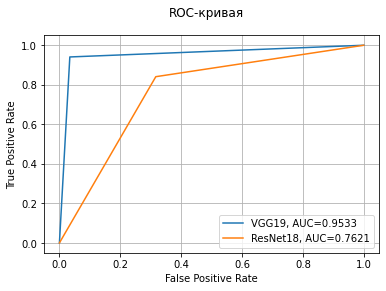

In [26]:
fpr_resnet18, tpr_resnet18, _ = metrics.roc_curve(np.array(y_list), np.array(model_prs))
auc_resnet18 = round(metrics.roc_auc_score(np.array(y_list), np.array(model_prs)), 4)
#plt.plot(fpr_rfc, tpr_rfc, label="Random Forest, AUC=" + str(auc_rfc))
plt.plot(fpr_vgg19, tpr_vgg19, label="VGG19, AUC=" + str(auc_vgg19))
plt.plot(fpr_resnet18, tpr_resnet18, label="ResNet18, AUC=" + str(auc_resnet18))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('ROC-кривая')
plt.grid(True)
plt.legend()
plt.show()

### Inception_v3

In [27]:
from torchvision.models import inception_v3

In [28]:
# Загружаем предобученную модель Inception v3
model = inception_v3(pretrained=True, aux_logits=False)  # отключаем aux классификатор для упрощения
for param in model.parameters():
    param.requires_grad = False

# Изменяем последний слой для бинарной классификации
model.fc = torch.nn.Linear(2048, 1)  # Inception v3 имеет 2048 выходов перед полносвязным слоем

# Явно устанавливаем использование CPU
device = torch.device("cpu")

# Переносим модель на устройство CPU
model.to(device);

print(model)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\zhark/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [29]:
# Подготавливаем изображение для входа в Inception
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # изменяем размер для соответствия Inception
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = torchvision.datasets.ImageFolder(root='handmade_apple_orange_dataset', transform=transform)

valid_size = int(len(dataset) * 0.1)
train_set, valid_set = torch.utils.data.random_split(dataset, (len(dataset)-valid_size, valid_size))
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [30]:
for epoch in range(1, n_epochs+1):
    train_loss = []
    for batch_i, (data, target) in enumerate(tqdm(train_dataloader)):
        data, target = data.to(device), target.to(device).unsqueeze(1).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()

    with torch.no_grad():
        # запускаем валидацию
        model.eval()
        val_loss = []
        for batch_i, (data, target) in enumerate(valid_dataloader):
            data, target = data.to(device), target.to(device).unsqueeze(1)
            output = model(data)
            loss = criterion(output, target.float())
            val_loss.append(loss.item())

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

100%|██████████| 36/36 [14:22<00:00, 23.95s/it]


Epoch 1, train loss: 0.7000, valid loss: 0.6846.


100%|██████████| 36/36 [13:48<00:00, 23.02s/it]


Epoch 2, train loss: 0.6713, valid loss: 0.6605.


100%|██████████| 36/36 [13:24<00:00, 22.36s/it]


Epoch 3, train loss: 0.6507, valid loss: 0.6402.


100%|██████████| 36/36 [13:41<00:00, 22.81s/it]


Epoch 4, train loss: 0.6315, valid loss: 0.6217.


100%|██████████| 36/36 [13:38<00:00, 22.74s/it]


Epoch 5, train loss: 0.6134, valid loss: 0.6038.


In [31]:
model.to(device)
model.eval()
pred_list = []; y_list = []
for x, y in valid_dataloader:
    with torch.no_grad():
        x = x.to(device)
        y = y.float().to(device)
        output = model(x)
        pred = torch.sigmoid(output)
        pred = pred.cpu().detach().numpy()
        for i in range(pred.shape[0]):
            pred_list.append(pred[i][0])
            y_list.append(int(y[i].item()))

model_prs = []
for model_pr, true_pr in zip(pred_list, y_list):
    model_pr = 1 if model_pr >= 0.5 else 0
    model_prs.append(model_pr)

In [32]:
# распечатаем результаты классификации на тестовой выборке
print(classification_report(np.array(y_list), np.array(model_prs)))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       111
           1       0.87      0.88      0.87       141

    accuracy                           0.86       252
   macro avg       0.86      0.85      0.85       252
weighted avg       0.86      0.86      0.86       252



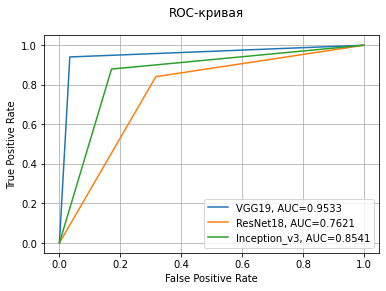

In [33]:
fpr_inception_v3, tpr_inception_v3, _ = metrics.roc_curve(np.array(y_list), np.array(model_prs))
auc_inception_v3 = round(metrics.roc_auc_score(np.array(y_list), np.array(model_prs)), 4)
plt.plot(fpr_vgg19, tpr_vgg19, label="VGG19, AUC=" + str(auc_vgg19))
plt.plot(fpr_resnet18, tpr_resnet18, label="ResNet18, AUC=" + str(auc_resnet18))
plt.plot(fpr_inception_v3, tpr_inception_v3, label="Inception_v3, AUC=" + str(auc_inception_v3))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('ROC-кривая')
plt.grid(True)
plt.legend()
plt.show()